## Import libraries

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from utils import load_wb_csv, filter_countries, reshape_long

## Load and Prepare Demographic Data

### Define Dataset Files
- List all CSV files containing demographic indicators
- Includes total, male, female population, working-age ratio, mortality, life expectancy and fertility rate

### Load CSV Files
- Use a helper function `load_wb_csv` to read each CSV into a pandas DataFrame
- Store all datasets in a dictionary for easy access

### Load Regions
- Read regions.csv to get ISO alpha-3 country codes

### Filter Countries
- Keep only valid countries based on the alpha-3 codes
- Remove aggregates or non-country entries

In [78]:
# Define dataset filenames for demographic indicators
files = {
    "total_population": "total_population.csv",
    "male_population": "male_population.csv",
    "female_population": "female_population.csv",
    "working_age_population_ratio": "working_age_population_ratio.csv",
    "mortality_rate": "mortality_rate.csv",
    "life_expectancy": "life_expectancy.csv",
    "life_expectancy_male": "life_expectancy_male.csv",
    "life_expectancy_female": "life_expectancy_female.csv",
    "fertility_rate": "fertility_rate.csv",
}

# Load each CSV file using a helper function and store in a dictionary
datasets = {name: load_wb_csv(fname) for name, fname in files.items()}

# Load regions
df_regions = pd.read_csv(r"D:\_Analysis\Projects\Global Indicators\Data\regions.csv")

# Extract list of country codes
alpha3_list = df_regions["alpha-3"].unique() 

# Filter each dataset to include only valid countries based on alpha-3 codes
for key in datasets:
    datasets[key] = filter_countries(datasets[key], alpha3_list)

print("Datasets loaded and cleaned successfully!")

Datasets loaded and cleaned successfully!


In [79]:
print(datasets["total_population"].head())

  Country Code       1960       1961       1962       1963       1964  \
0          ABW    54922.0    55578.0    56320.0    57002.0    57619.0   
2          AFG  9035043.0  9214083.0  9404406.0  9604487.0  9814318.0   
4          AGO  5231654.0  5301583.0  5354310.0  5408320.0  5464187.0   
5          ALB  1608800.0  1659800.0  1711319.0  1762621.0  1814135.0   
6          AND     9510.0    10283.0    11086.0    11915.0    12764.0   

         1965        1966        1967        1968  ...        2015  \
0     58190.0     58694.0     58990.0     59069.0  ...    107906.0   
2  10036008.0  10266395.0  10505959.0  10756922.0  ...  33831764.0   
4   5521981.0   5581386.0   5641807.0   5702699.0  ...  28157798.0   
5   1864791.0   1914573.0   1965598.0   2022272.0  ...   2880703.0   
6     13634.0     14626.0     15837.0     17176.0  ...     72174.0   

         2016        2017        2018        2019        2020        2021  \
0    108727.0    108735.0    108908.0    109203.0    108587.0  

In [80]:
datasets["total_population"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 215 entries, 0 to 265
Data columns (total 66 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  215 non-null    object 
 1   1960          214 non-null    float64
 2   1961          214 non-null    float64
 3   1962          214 non-null    float64
 4   1963          214 non-null    float64
 5   1964          214 non-null    float64
 6   1965          214 non-null    float64
 7   1966          214 non-null    float64
 8   1967          214 non-null    float64
 9   1968          214 non-null    float64
 10  1969          214 non-null    float64
 11  1970          214 non-null    float64
 12  1971          214 non-null    float64
 13  1972          214 non-null    float64
 14  1973          214 non-null    float64
 15  1974          214 non-null    float64
 16  1975          214 non-null    float64
 17  1976          214 non-null    float64
 18  1977          214 non-null    float

## Reshape and Merge Data

### Reshape Datasets to Long Format
- Convert each dataset from wide format to long format using `reshape_long`

### Merge Datasets
- Start with `total_population` as the base dataframe
- Merge other datasets on `country_code` and `year` using left join

In [81]:
# Convert each dataset from wide format to long format using a helper function
long_datasets = {name: reshape_long(df, name) for name, df in datasets.items()}

# Start with total_population as the base dataframe
df_population = long_datasets["total_population"]

# Merge all other datasets into the base dataframe on country_code and year
# Use left join to keep all rows from total_population
for name, df in long_datasets.items():
    if name != "total_population":
        df_population = df_population.merge(df, on=["country_code", "year"], how="left")

print("All datasets successfully reshaped and merged!")
print(df_population.head())

All datasets successfully reshaped and merged!
  country_code  year  total_population  male_population  female_population  \
0          ABW  1960           54922.0          26995.0            27927.0   
1          AFG  1960         9035043.0        4690245.0          4344798.0   
2          AGO  1960         5231654.0        2649099.0          2582555.0   
3          ALB  1960         1608800.0         810328.0           798472.0   
4          AND  1960            9510.0           4818.0             4692.0   

   working_age_population_ratio  mortality_rate  life_expectancy  \
0                     83.046159             NaN           64.049   
1                     81.061389           251.2           32.799   
2                     79.938393             NaN           37.933   
3                     87.482447             NaN           56.413   
4                     51.569721             NaN           72.094   

   life_expectancy_male  life_expectancy_female  fertility_rate  
0        

## Data Consistency Check: Population Totals

### Calculate Difference
- Compute the difference between the sum of male and female populations and the total population
- Store the result in a new column `diff`

In [82]:
# Check consistency between male + female and total population
df_population["diff"] = (
    df_population["male_population"] + df_population["female_population"]
) - df_population["total_population"]

# Rows where values do not match
df_mismatch = df_population[df_population["diff"] != 0]

if df_mismatch.empty:
    print("All values are consistent: male_population + female_population == total_population.")
else:
    print("Found mismatches where male + female != total population:")
    print(df_mismatch[["country_code", "year", "total_population", "male_population", "female_population", "diff"]])

df_population = df_population.drop(columns=["diff"])

Found mismatches where male + female != total population:
     country_code  year  total_population  male_population  female_population  \
160           PSE  1960               NaN              NaN                NaN   
375           PSE  1961               NaN              NaN                NaN   
590           PSE  1962               NaN              NaN                NaN   
805           PSE  1963               NaN              NaN                NaN   
1020          PSE  1964               NaN              NaN                NaN   
1235          PSE  1965               NaN              NaN                NaN   
1450          PSE  1966               NaN              NaN                NaN   
1665          PSE  1967               NaN              NaN                NaN   
1880          PSE  1968               NaN              NaN                NaN   
2095          PSE  1969               NaN              NaN                NaN   
2310          PSE  1970               NaN          

## Correlation Analysis

### Load Economic Data
- Read the preprocessed economic indicators from `df_economics.csv`

### Merge Datasets
- Merge population and economic data on `country_code` and `year` using a left join
- Resulting dataframe `df_merged` contains all demographic and economic indicators

### Select Numeric Columns
- Extract only numeric columns (`int64` and `float64`) for correlation analysis

### Compute Correlation Matrix
- Calculate pairwise correlations between all numeric variables

### Visualize Correlations
- Plot a heatmap using Seaborn
- Annotate values, set color map to `coolwarm`, and adjust figure size

In [83]:
df_economics = pd.read_csv("df_economics.csv")

In [84]:
df_population["year"] = df_population["year"].astype(int)
df_economics["year"] = df_economics["year"].astype(int)

df_merged = df_population.merge(
    df_economics,
    on=["country_code", "year"],
    how="left"
)

df_merged = df_merged.merge(
    df_regions[["alpha-3", "region"]],
    left_on="country_code",
    right_on="alpha-3",
    how="left"
)

df_merged = df_merged.drop(columns=["alpha-3"])

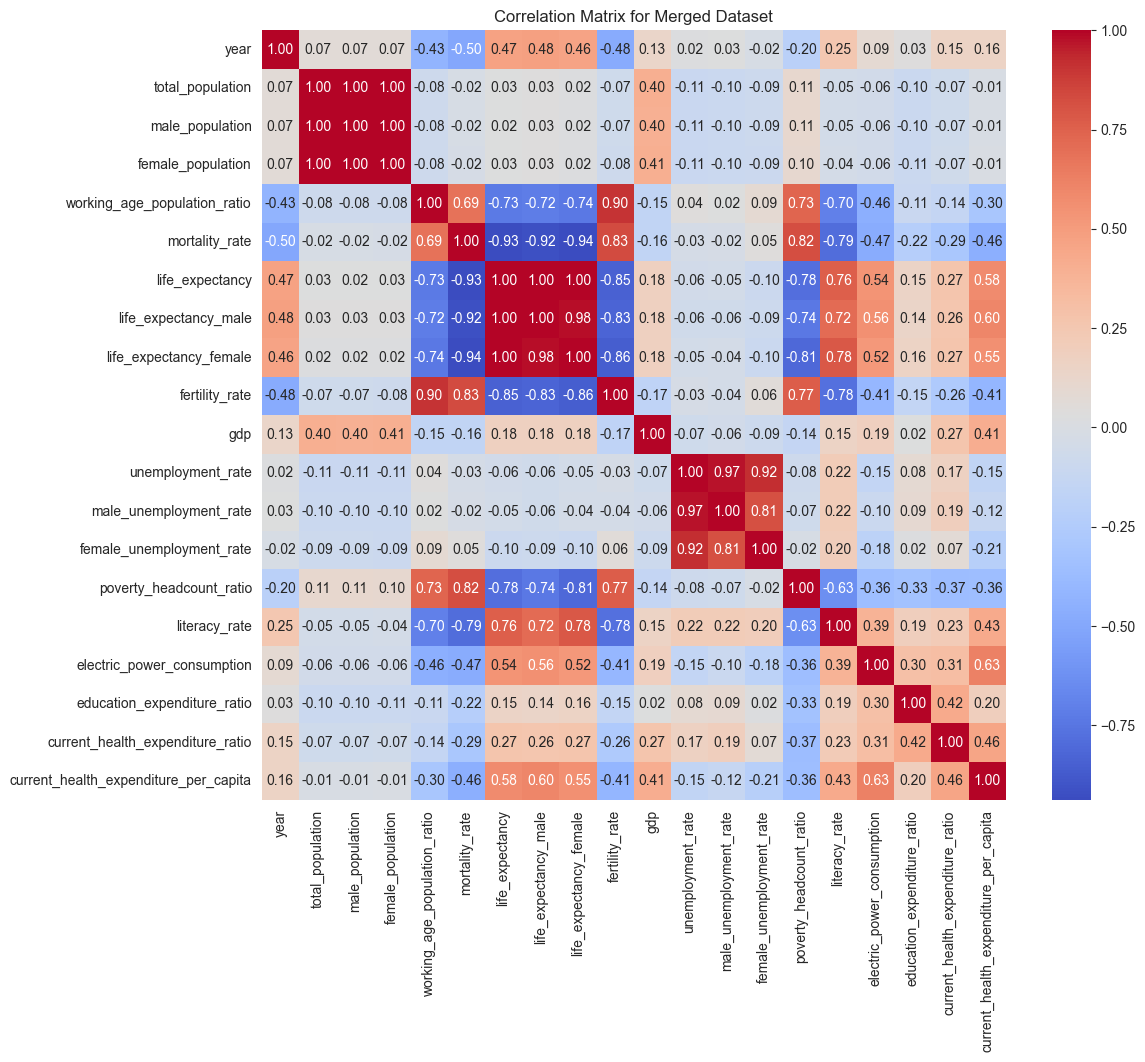

In [85]:
df_num = df_merged.select_dtypes(include=["int64", "float64"])

corr_matrix = df_num.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for Merged Dataset")
plt.show()

## Visualize Population Trends for Ukraine

### Filter Data
- Select only the data for Ukraine (`country_code == "UKR"`)
- Create a copy to avoid modifying the original dataframe

### Plot Population Line Chart
- Plot total population over time (1960–2024)
- Add markers for each data point for clarity
- Set figure size for better readability

### Titles and Labels
- Title: "Population of Ukraine (1960–2024)"
- X-axis: Year
- Y-axis: Population

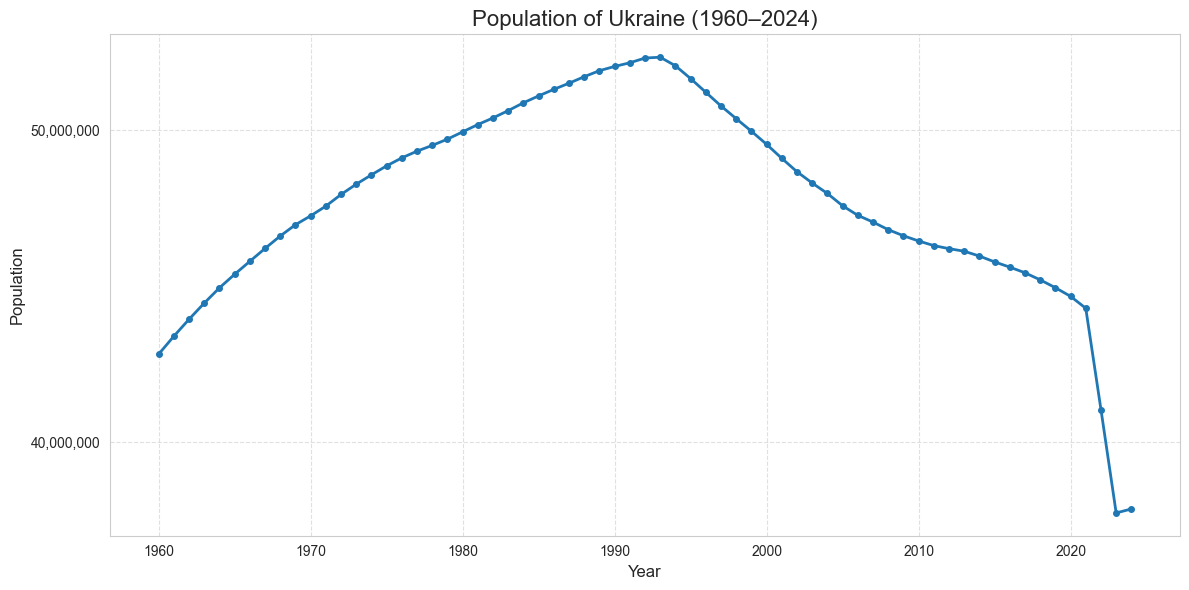

In [86]:
# Filter data for Ukraine
df_ukr = df_population[df_population["country_code"] == "UKR"].copy()

plt.figure(figsize=(12, 6))

# Plot the line chart
plt.plot(
    df_ukr["year"],
    df_ukr["total_population"],
    linewidth=2,
    marker="o",
    markersize=4
)

# Titles and labels
plt.title("Population of Ukraine (1960–2024)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Population", fontsize=12)

# Format axes
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10_000_000))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## Regional Analysis of Key Demographic Indicators

In this section, we visualize **median values of key demographic indicators** across regions over time.

### Median Life Expectancy by Region
- Calculate the median `life_expectancy` per region for each year.

### Median Fertility Rate by Region
- Calculate the median `fertility_rate` per region for each year.

### Median Working Age Population Ratio by Region
- Calculate the median `working_age_population_ratio` per region for each year.

These visualizations allow us to compare **demographic trends** across regions over time and observe patterns in life expectancy, fertility and the working-age population.

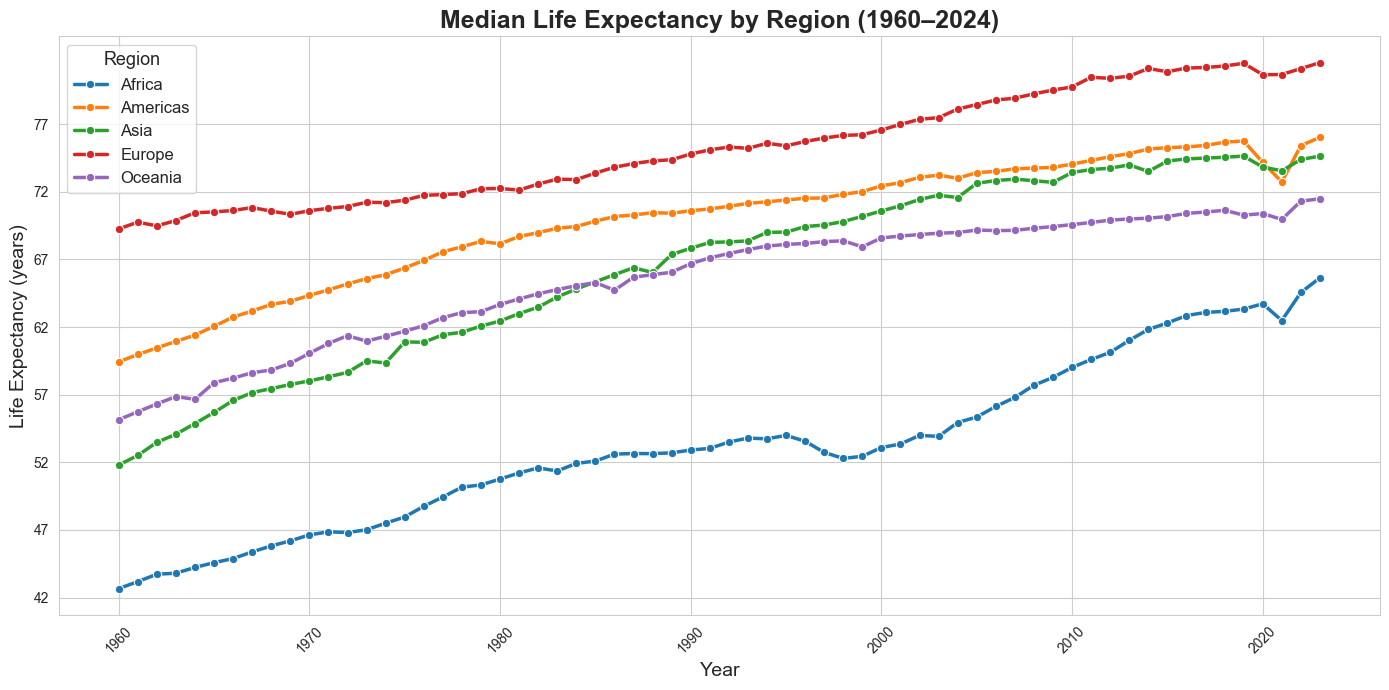

In [87]:
# Median Life Expectancy by Region
df_region = df_merged.groupby(["region", "year"])["life_expectancy"].median().reset_index()

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_region,
    x="year",
    y="life_expectancy",
    hue="region",
    marker="o",
    linewidth=2.5,
    palette="tab10"
)

plt.title("Median Life Expectancy by Region (1960–2024)", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Life Expectancy (years)", fontsize=14)

plt.xticks(rotation=45)
plt.yticks(range(int(df_region["life_expectancy"].min()), int(df_region["life_expectancy"].max()) + 1, 5))

plt.legend(title="Region", fontsize=12, title_fontsize=13, loc="upper left")

plt.tight_layout()

plt.show()

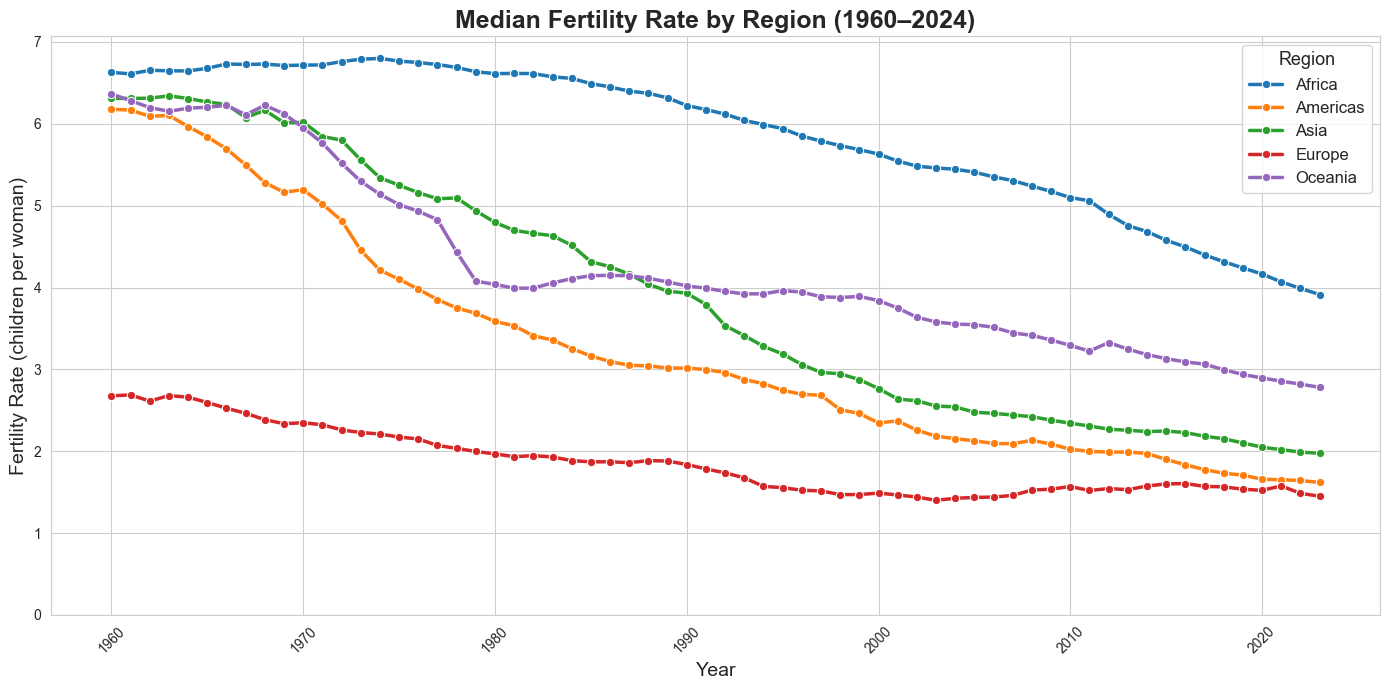

In [88]:
# Median Fertility Rate by Region
df_region_fertility = df_merged.groupby(["region", "year"])["fertility_rate"].median().reset_index()

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_region_fertility,
    x="year",
    y="fertility_rate",
    hue="region",
    marker="o",
    linewidth=2.5,
    palette="tab10"
)

plt.title("Median Fertility Rate by Region (1960–2024)", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Fertility Rate (children per woman)", fontsize=14)

plt.xticks(rotation=45)
plt.yticks([i for i in range(0, int(df_region_fertility["fertility_rate"].max()) + 2)])

plt.legend(title="Region", fontsize=12, title_fontsize=13, loc="upper right")

plt.tight_layout()
plt.show()

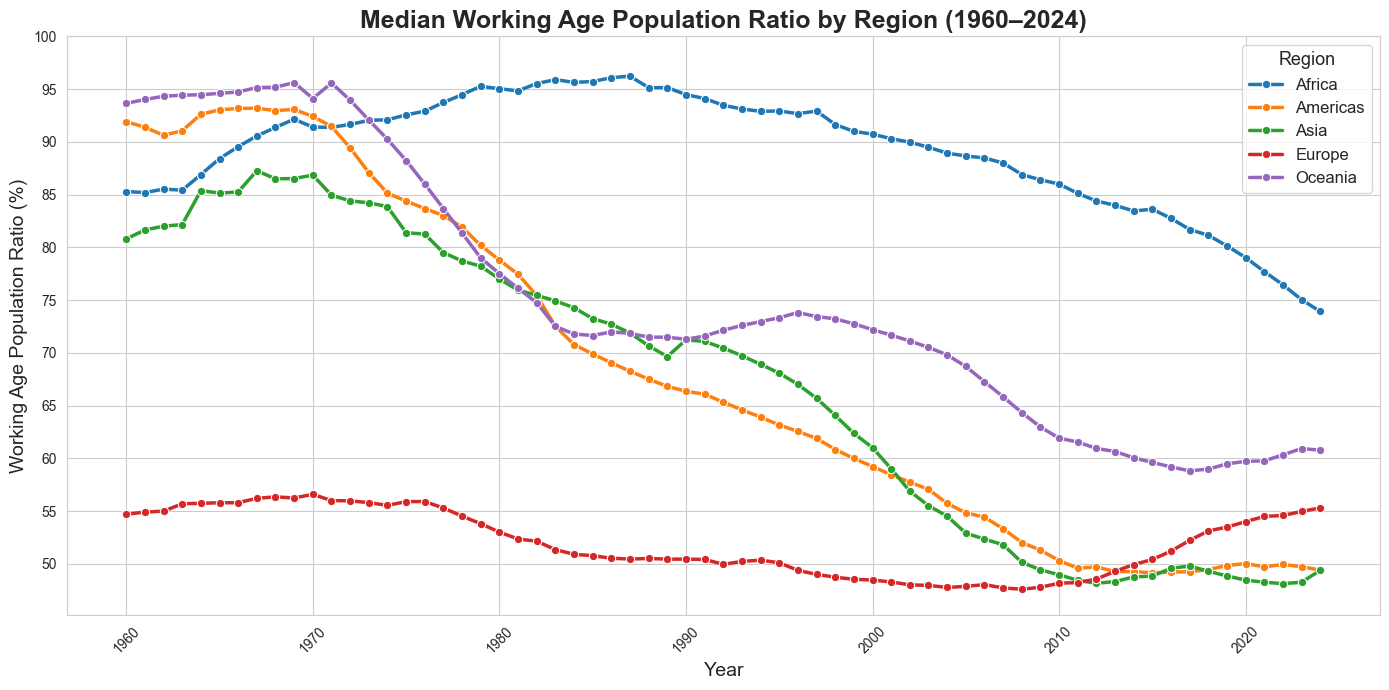

In [89]:
# Median Working Age Population Ratio by Region
df_region_working_age = df_merged.groupby(["region", "year"])["working_age_population_ratio"].median().reset_index()

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_region_working_age,
    x="year",
    y="working_age_population_ratio",
    hue="region",
    marker="o",
    linewidth=2.5,
    palette="tab10"
)

plt.title("Median Working Age Population Ratio by Region (1960–2024)", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Working Age Population Ratio (%)", fontsize=14)

plt.xticks(rotation=45)
plt.yticks(range(50, 101, 5)) 

plt.legend(title="Region", fontsize=12, title_fontsize=13, loc="upper right")

plt.tight_layout()
plt.show()

## Export Population CSV file

In [90]:
df_population.to_csv("df_population.csv", index=False)